# 1. Importing Libraries

In [23]:
import pandas as pd
import sklearn 
import joblib
#import matlplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from feature_engine.datetime import DatetimeFeatures
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [24]:
sklearn.set_config(transform_output="default")
pd.set_option("display.max_columns",None)

# 2. Getting Data

In [25]:
train_df=pd.read_csv("data/train.csv")
test_df=pd.read_csv("data/test.csv")
val_df=pd.read_csv("data/val.csv")

In [26]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


In [27]:
# 3.1 splitting data


In [28]:
def split(df):
    X= df.drop(columns= "price")
    y= df.price.copy()
    return X,y

In [29]:
X_train,y_train = split(train_df)

In [30]:
X_test,y_test = split(test_df)
X_val,y_val = split(val_df)

In [31]:
#3.2 Meta info

In [32]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


In [33]:
# 4. Data pre processing

In [34]:
num_cols = ["duration","total_stops"]
dt_cols =["date_of_journey","dep_time","arrival_time"]

cat_col= [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [35]:
num_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])
cat_pipe = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])
doj_transformer = Pipeline(steps=[
 ("imputer",SimpleImputer(strategy="most_frequent")),
 ("extractor",DatetimeFeatures(features_to_extract=['month','week','day_of_week','day_of_month'],format="mixed")),
     ("scaler",StandardScaler())
])

time_transformer = Pipeline(steps=[
 ("imputer",SimpleImputer(strategy="most_frequent")),
 ("extractor",DatetimeFeatures(features_to_extract=['hour','minute'],format="mixed")),
     ("scaler",StandardScaler())
])

In [36]:
preprocessor= ColumnTransformer(transformers=[
    ("num",num_pipe,num_cols),
    ("cat",cat_pipe,cat_col),
    ("doj",doj_transformer,["date_of_journey"]),
    ("time",time_transformer,["dep_time","arrival_time"])
])

In [37]:
num_cols,cat_col

(['duration', 'total_stops'],
 ['airline', 'source', 'destination', 'additional_info'])

In [38]:
X_train.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info'],
      dtype='object')

In [39]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

In [40]:
#model selection

C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\model_selection\_validation.py:2050: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 5.
  warnings.warn(
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


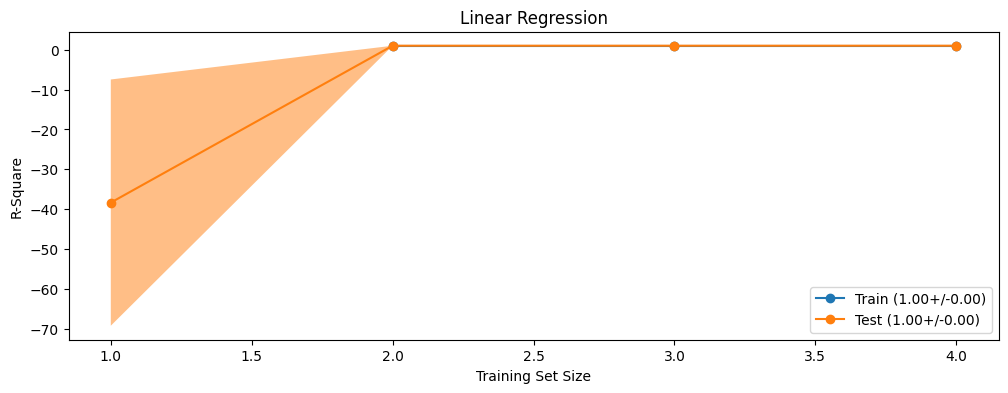

C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\model_selection\_validation.py:2050: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 5.
  warnings.warn(
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


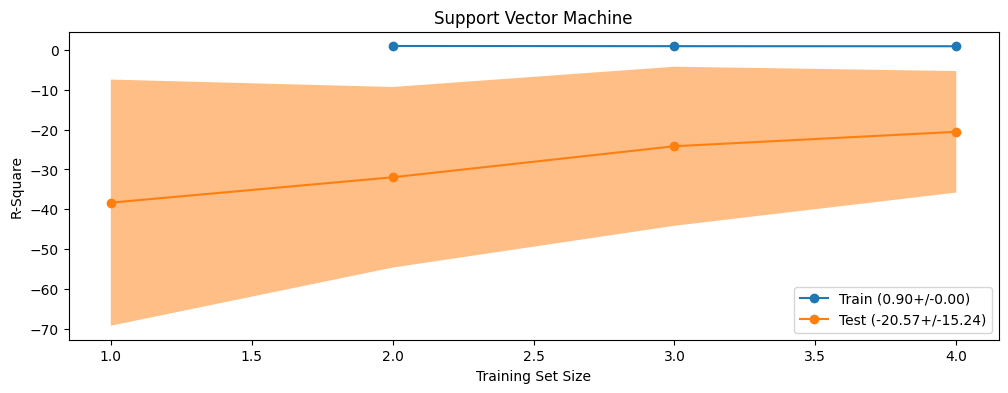

C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\model_selection\_validation.py:2050: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 5.
  warnings.warn(
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


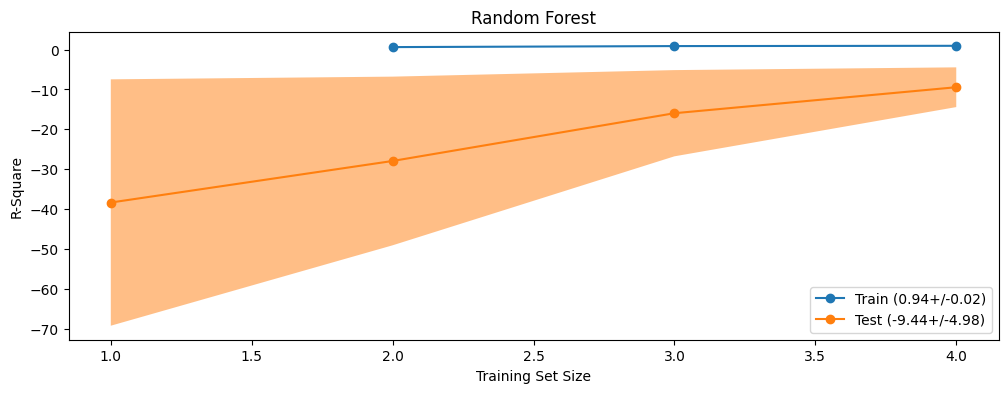

C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\model_selection\_validation.py:2050: RuntimeWarning: Removed duplicate entries from 'train_sizes'. Number of ticks will be less than the size of 'train_sizes': 4 instead of 5.
  warnings.warn(
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Test\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


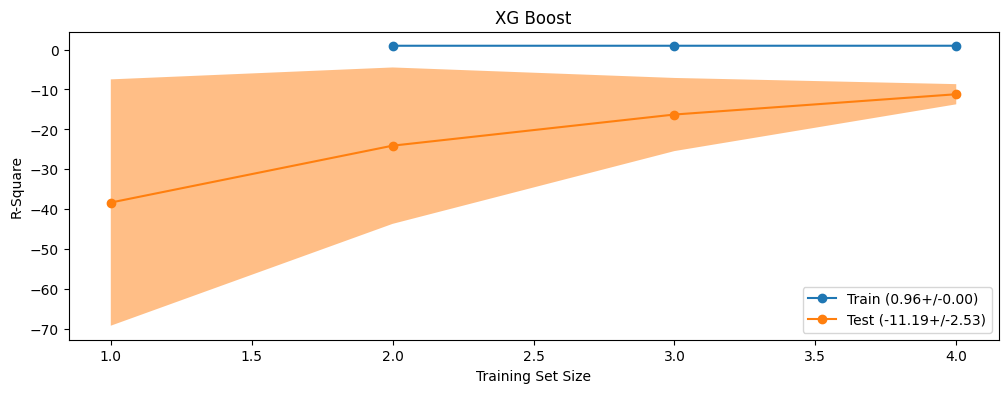

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

# Dummy data functions (replace with actual data loading and splitting)
def split(data):
    X_data = data.drop(columns=["target_column"])  # Replace with actual target column name
    y_data = data["target_column"]  # Replace with actual target column name
    return X_data, y_data

# Dummy concatenation (replace with actual data loading)
train_df = pd.DataFrame({"feature1": [1, 2, 3], "target_column": [4, 5, 6]})
test_df = pd.DataFrame({"feature1": [4, 5, 6], "target_column": [7, 8, 9]})

algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

def plot_learning_curve(name, algorithms, figsize=(12, 4)):
    model = Pipeline(steps=[
        # Replace preprocessor with your actual preprocessing steps
        ("pre", None),  # Placeholder for preprocessor
        ("alg", algorithms)
    ])
    
    X_data, y_data = split(pd.concat([train_df, test_df], axis=0))  # Concatenating train and test data
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_data,
        y=y_data,
        cv=3,
        scoring="r2",
        n_jobs=1,
        random_state=42
    )
    
    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    train_score = f"{mean_train_scores[-1]:.2f}+/-{std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    test_score = f"{mean_test_scores[-1]:.2f}+/-{std_test_scores[-1]:.2f}"
    
    fig, ax = plt.subplots(figsize=figsize)
    
    plt_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({train_score})",
        ax
    )
    
    plt_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({test_score})",
        ax
    )
    
    ax.set(xlabel="Training Set Size", ylabel="R-Square", title=name)
    ax.legend(loc="lower right")  # Corrected the location
    plt.show()

def plt_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    
    ax.fill_between(
        sizes,
        mean_scores - std_scores,
        mean_scores + std_scores,
        alpha=0.5
    )

# Calling the function for each algorithm
for name, alg in algorithms.items():
    plot_learning_curve(name, alg)


In [42]:
model = Pipeline(steps=[
    ("pre",preprocessor),
    ("rf",RandomForestRegressor(n_estimators=10))
])

In [47]:
model.fit(X_test,y_test)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [48]:
def evaluate_model(X,y):
    y_pred= model.predict(X)
    return r2_score(y,y_pred)

In [49]:
print(evaluate_model(X_val,y_val))

0.6644369861175656


In [50]:
print(evaluate_model(X_test,y_test))

0.9536379604064305


In [51]:
joblib.dump(model,"model.joblib")

['model.joblib']

In [52]:
saved_model= joblib.load("model.joblib")

In [53]:
y_pred= saved_model.predict(X_test)
r2_score(y_test,y_pred)

0.9536379604064305

In [54]:
saved_model


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])